In [71]:
# packacges
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 
import pickle 
# encoder 
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from lightgbm.sklearn import LGBMClassifier
from sklearn import svm
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import optuna

from sklearn.preprocessing import MinMaxScaler

#suppress warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="No further splits with positive gain")
warnings.filterwarnings("ignore", message="Found whitespace in feature_names, replace with underlines")



## 1. Dataset Onboarding

In [3]:
df = pd.read_csv("predictive_maintenance.csv")

In [4]:
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

In [5]:
df.shape

(10000, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


## 2. Exploratory Data Analysis

In [7]:
# Drop unnecessary columns
# UDI is unique ID which is not needed as we already have product ID as the unique identifier
# 'Target' is also unnecessary as we will predct the Failure Type
df = df.drop(['UDI', 'Product ID', 'Target'], axis = 1) 

In [8]:
# Univariate Analysis (Plotting)

In [9]:
# get the categorical and numerical features 
cat_features = df.select_dtypes(include=['object'])
num_features = df.select_dtypes(['float64', 'int64'])

In [10]:
def plot(feature, kind): 
    plt.figure(figsize=(16, 10)) 
    if kind =='box' or kind == 'count': 
        sns.catplot(x=feature, kind=kind, data=df, color='skyblue') 
    elif kind =='hist':
        sns.histplot(data = df, x= feature, color='skyblue')
    
    plt.title(f"{feature} Count Plot")   
    plt.xlabel(f"{feature}")  
    plt.ylabel("Total Count") 
    plt.xticks(rotation=45) 
    if kind == 'count':
        ax = plt.gca()  # Get the current axis 
        for p in ax.patches:  
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 5), 
                        textcoords = 'offset points') 
    
    plt.show()

<Figure size 1600x1000 with 0 Axes>

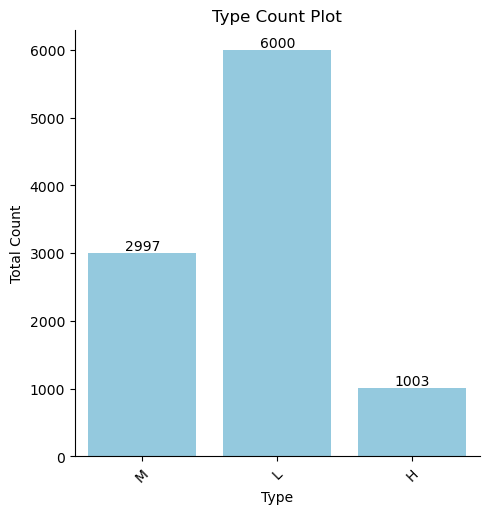

<Figure size 1600x1000 with 0 Axes>

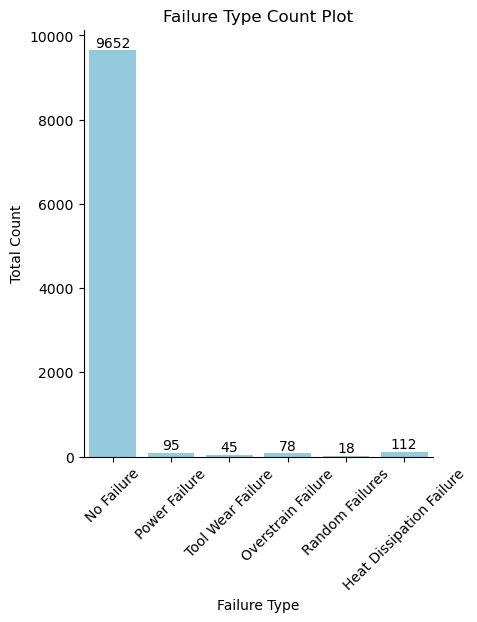

In [11]:
# Categorical Features Plot
for feature in cat_features.columns:
    plot(feature, 'count')

**Target feature (Failure Type) has imbalance issues**

<Figure size 1600x1000 with 0 Axes>

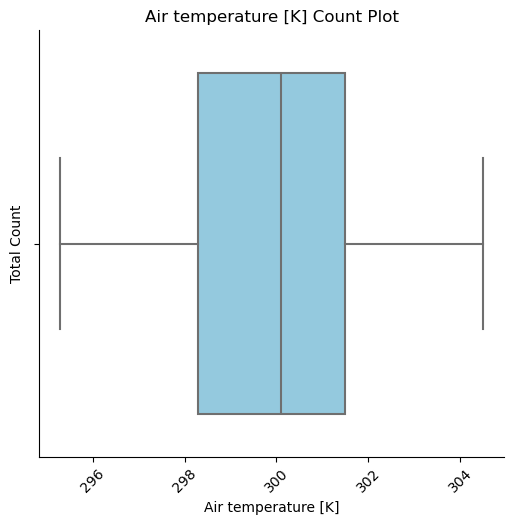

<Figure size 1600x1000 with 0 Axes>

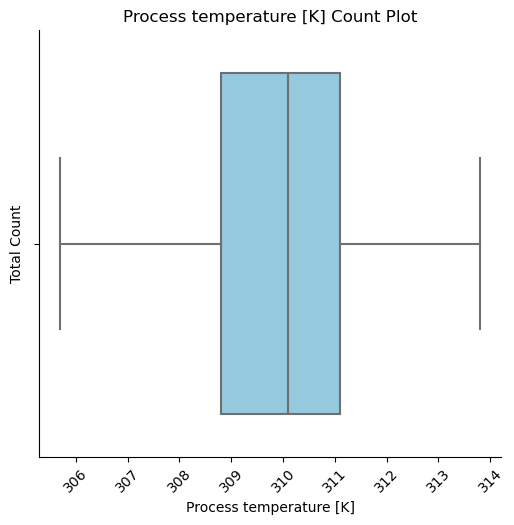

<Figure size 1600x1000 with 0 Axes>

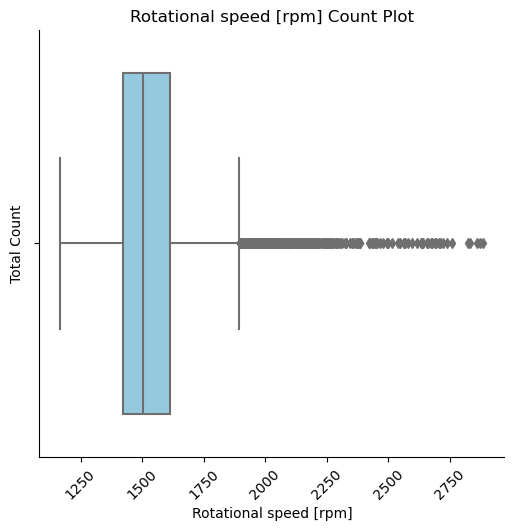

<Figure size 1600x1000 with 0 Axes>

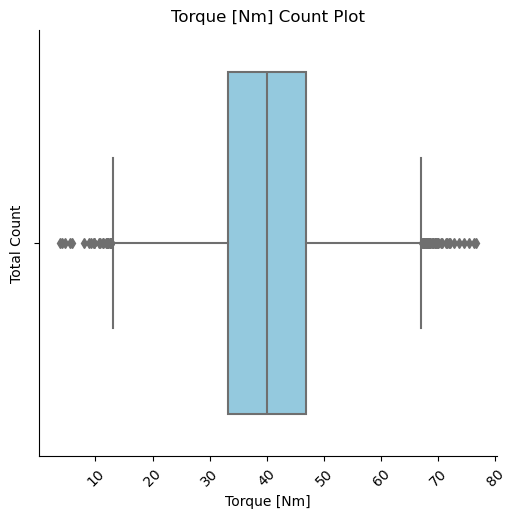

<Figure size 1600x1000 with 0 Axes>

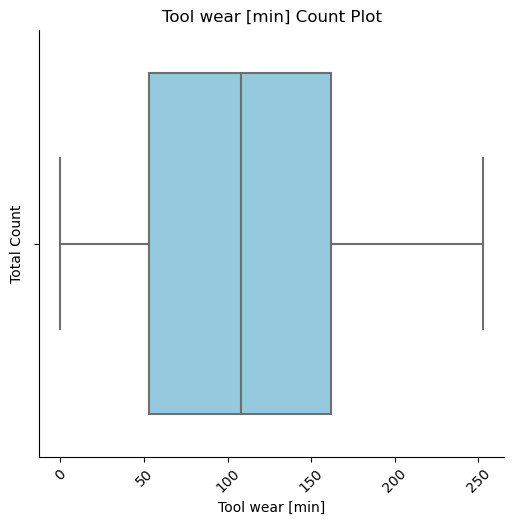

In [13]:
# Numerical Features BoxPlot 
for feature in num_features: 
    plot(feature, 'box')

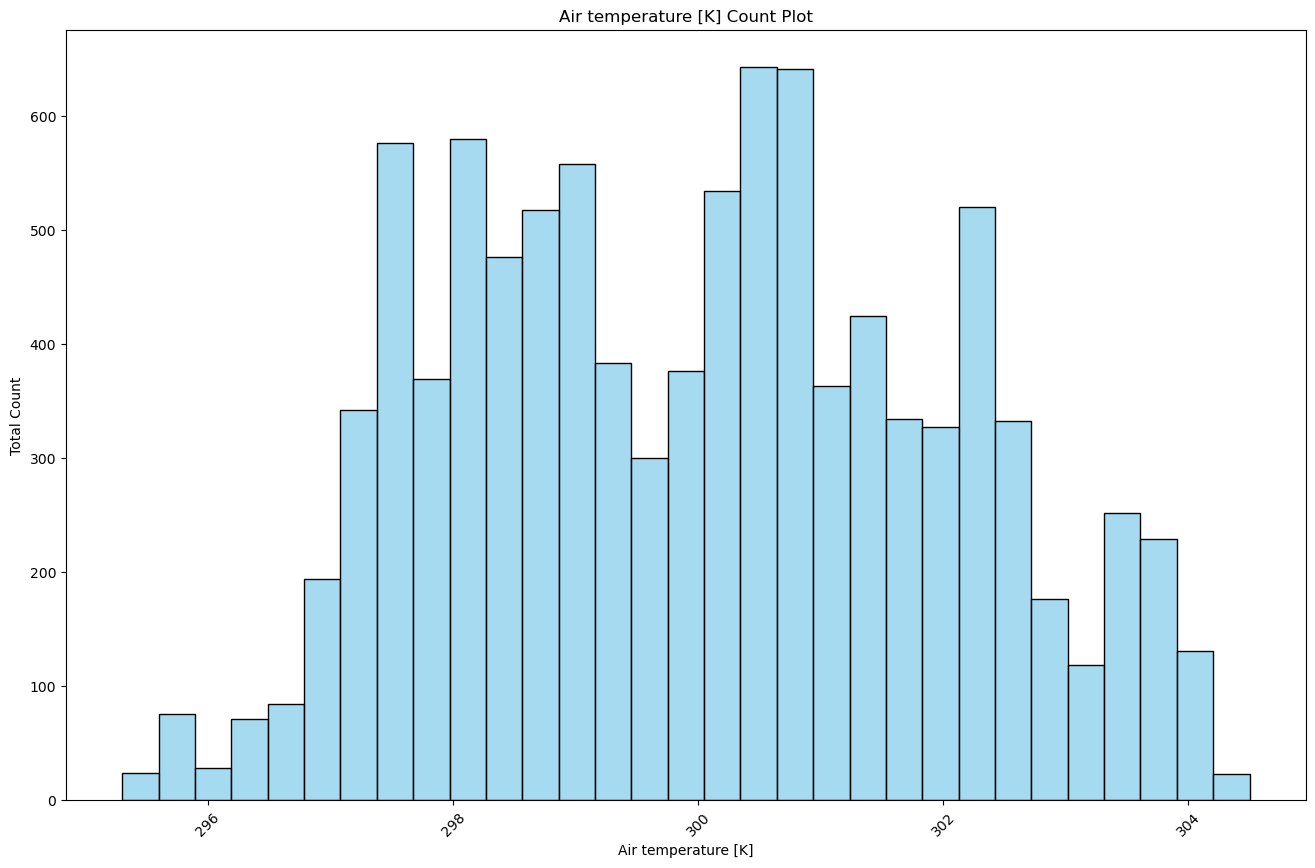

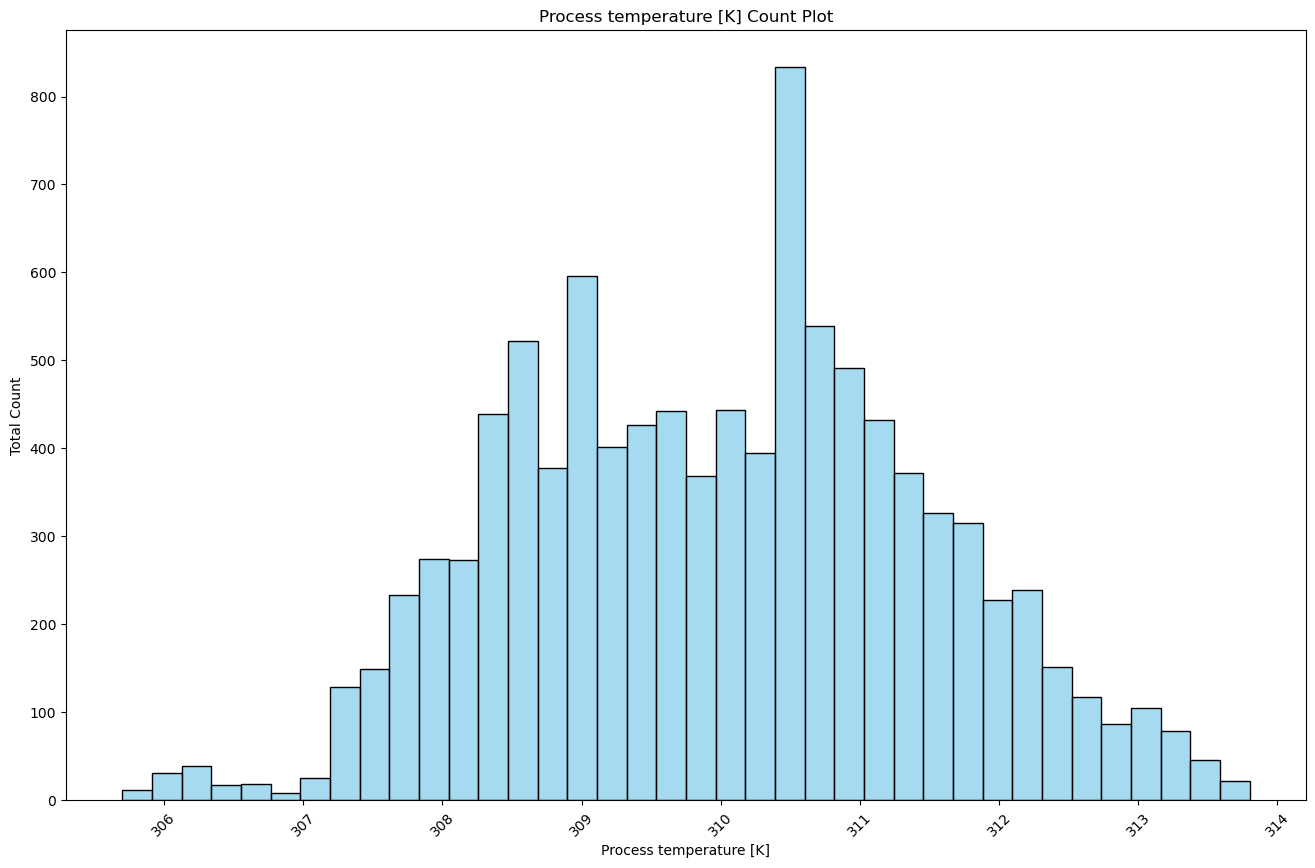

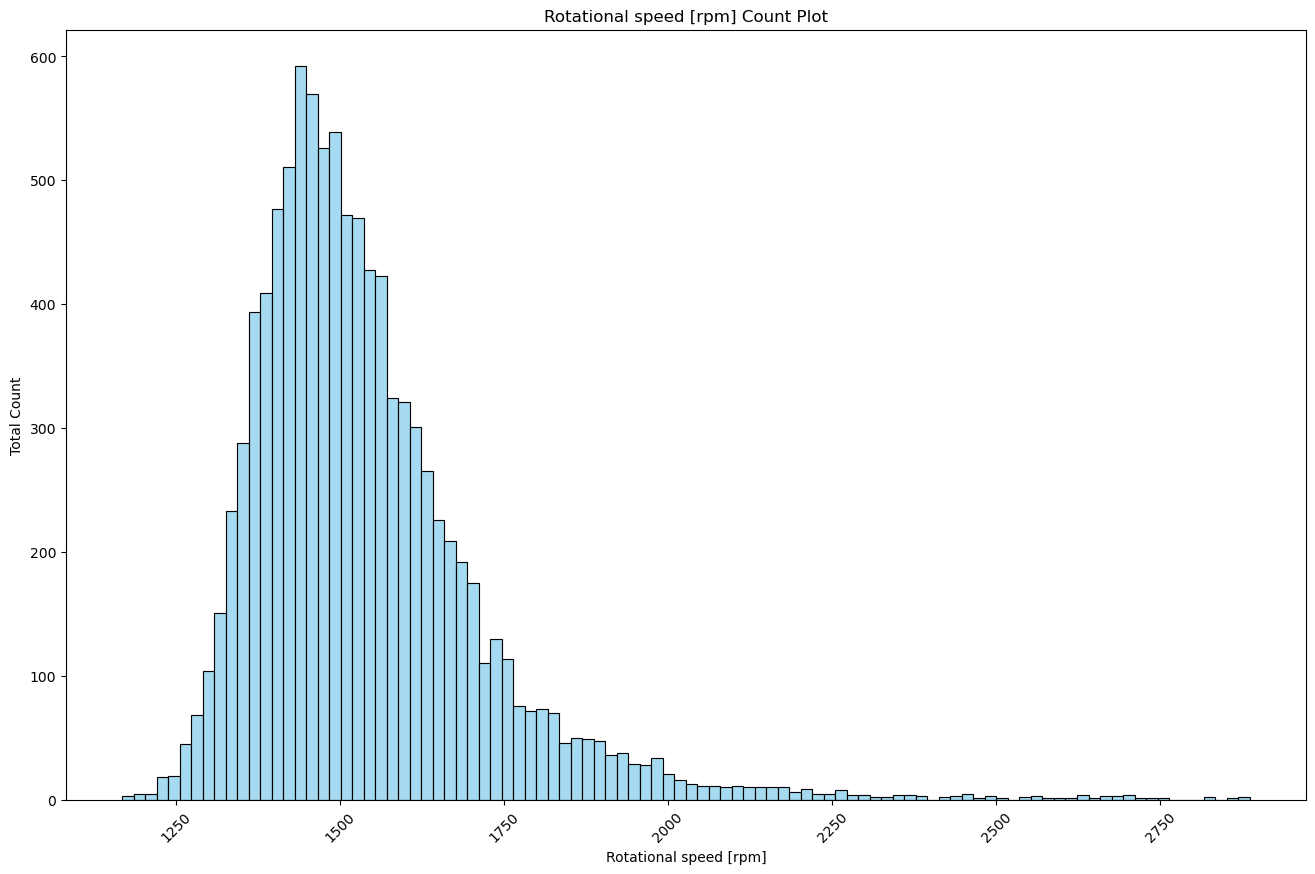

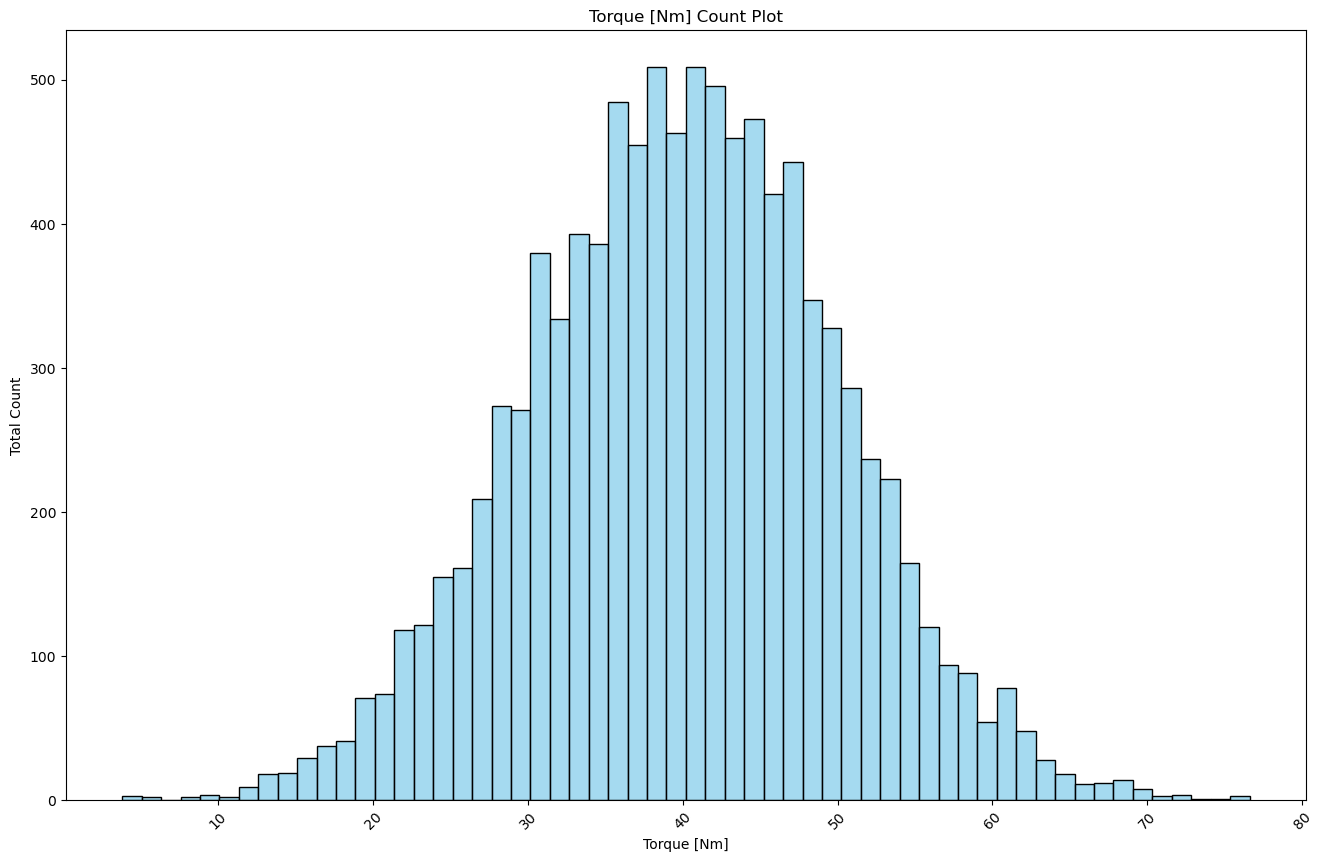

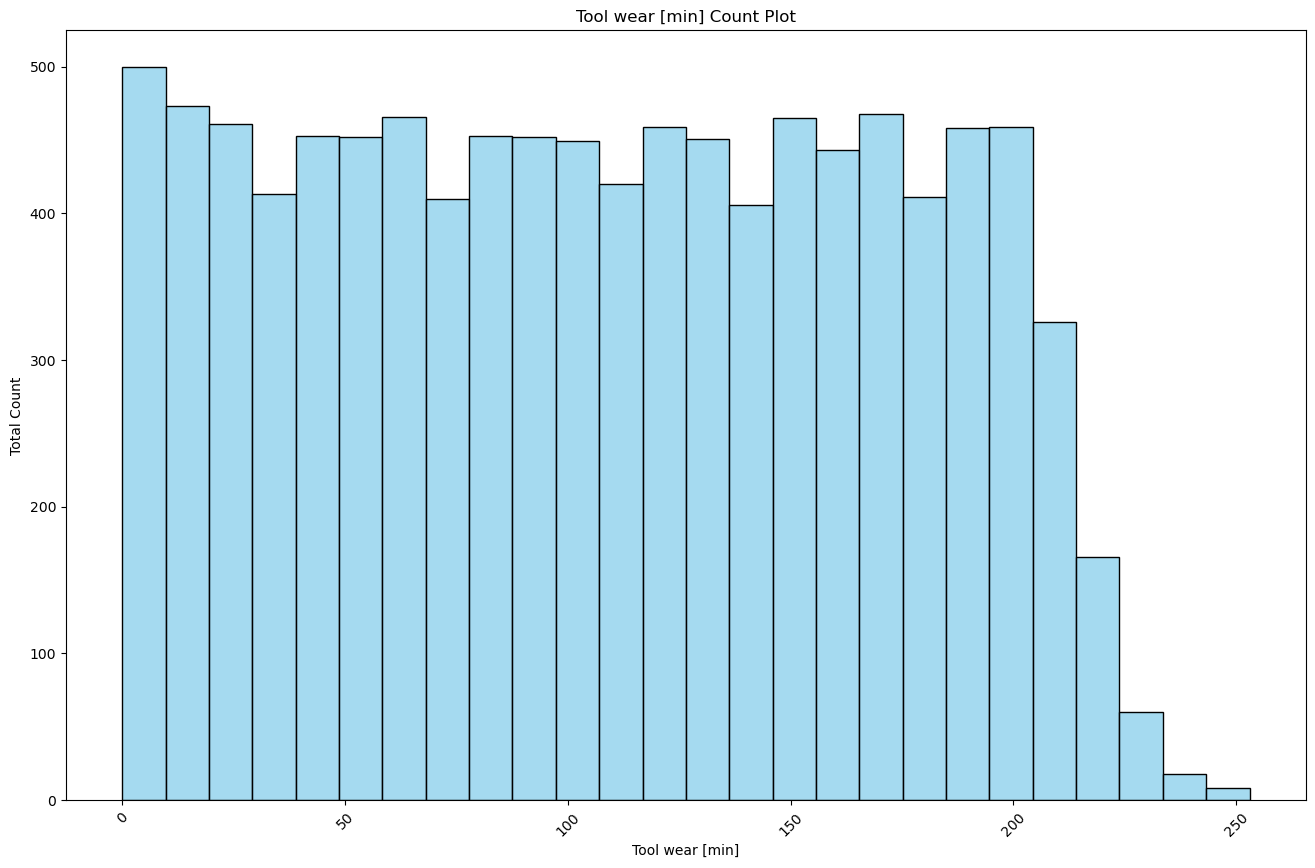

In [14]:
# Numerical Features histogram
for feature in num_features:
    plot(feature, 'hist')

In [15]:
# numeric descriptive analysis 
num_features.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]  
count  10000.000000     10000.000000  
mean      39.986910       107.951000  
std        9.968934        63.654147  
min        3.800000         0.000000  
25%       33.200000        53.000000  
50%       40.100000       108.000000  
75%       46.800000       162.000000  
max       76.600000       253.000000

In [16]:
# Bivariate Analysis

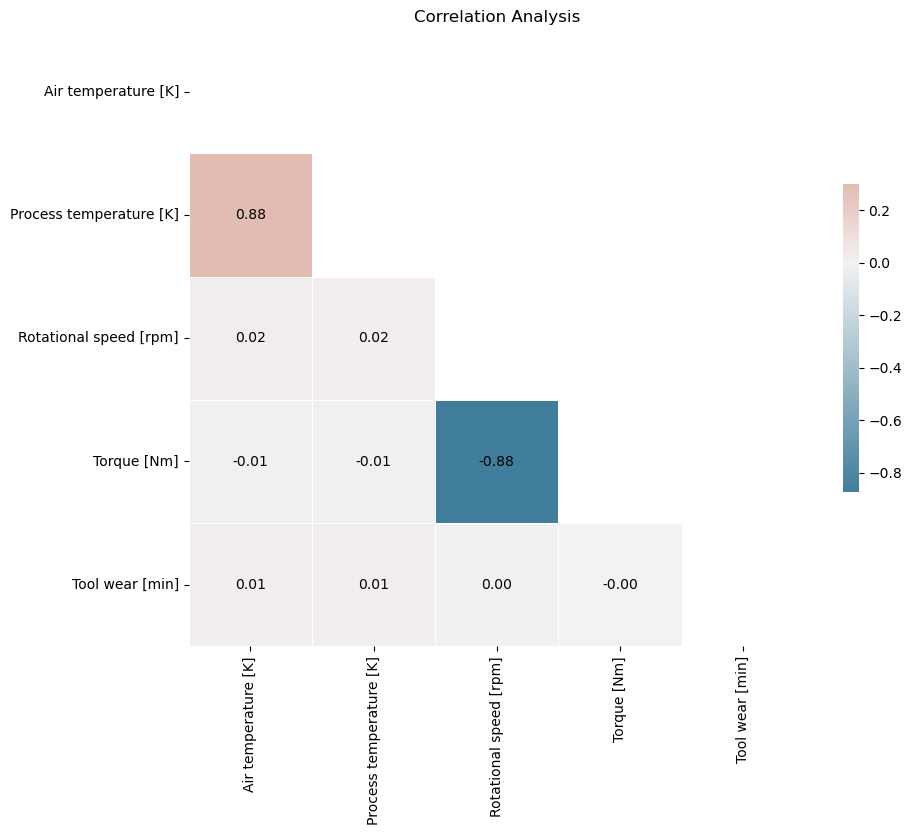

In [17]:
def correlation(data):
    # Correation Analysis
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                    )

    # Annotate only the visible cells
    for i in range(len(corr)):
        for j in range(len(corr)):
            if mask[i, j] == False:
                plt.text(j + 0.5, i + 0.5, f'{corr.iloc[i, j]:.2f}',
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=10, color='black')
    plt.title('Correlation Analysis')
    plt.show()

correlation(num_features)

**Process Temperature (K) and Air Temperature features are highly correlated (0.88) also Torque and Rotational Speed are highly correlated. We may be able to remove one from each of these group as they possess high correlation**

In [18]:
def bivariate_plot(target_feature, x_feature):

    # Check if the x feature is categorical or numerical
    if df[x_feature].dtype == 'object':
        # Categorical x feature
        g = sns.catplot(x=x_feature, row=target_feature, kind='count', data=df, height=4, aspect=1.5)
        for ax in g.axes.flat:
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 5), 
                            textcoords = 'offset points')
    else:
        # Numerical x feature
        g = sns.catplot(x=target_feature, y=x_feature, data=df, kind='box', height=4, aspect=1.5)
        for ax in g.axes.flat:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.show()

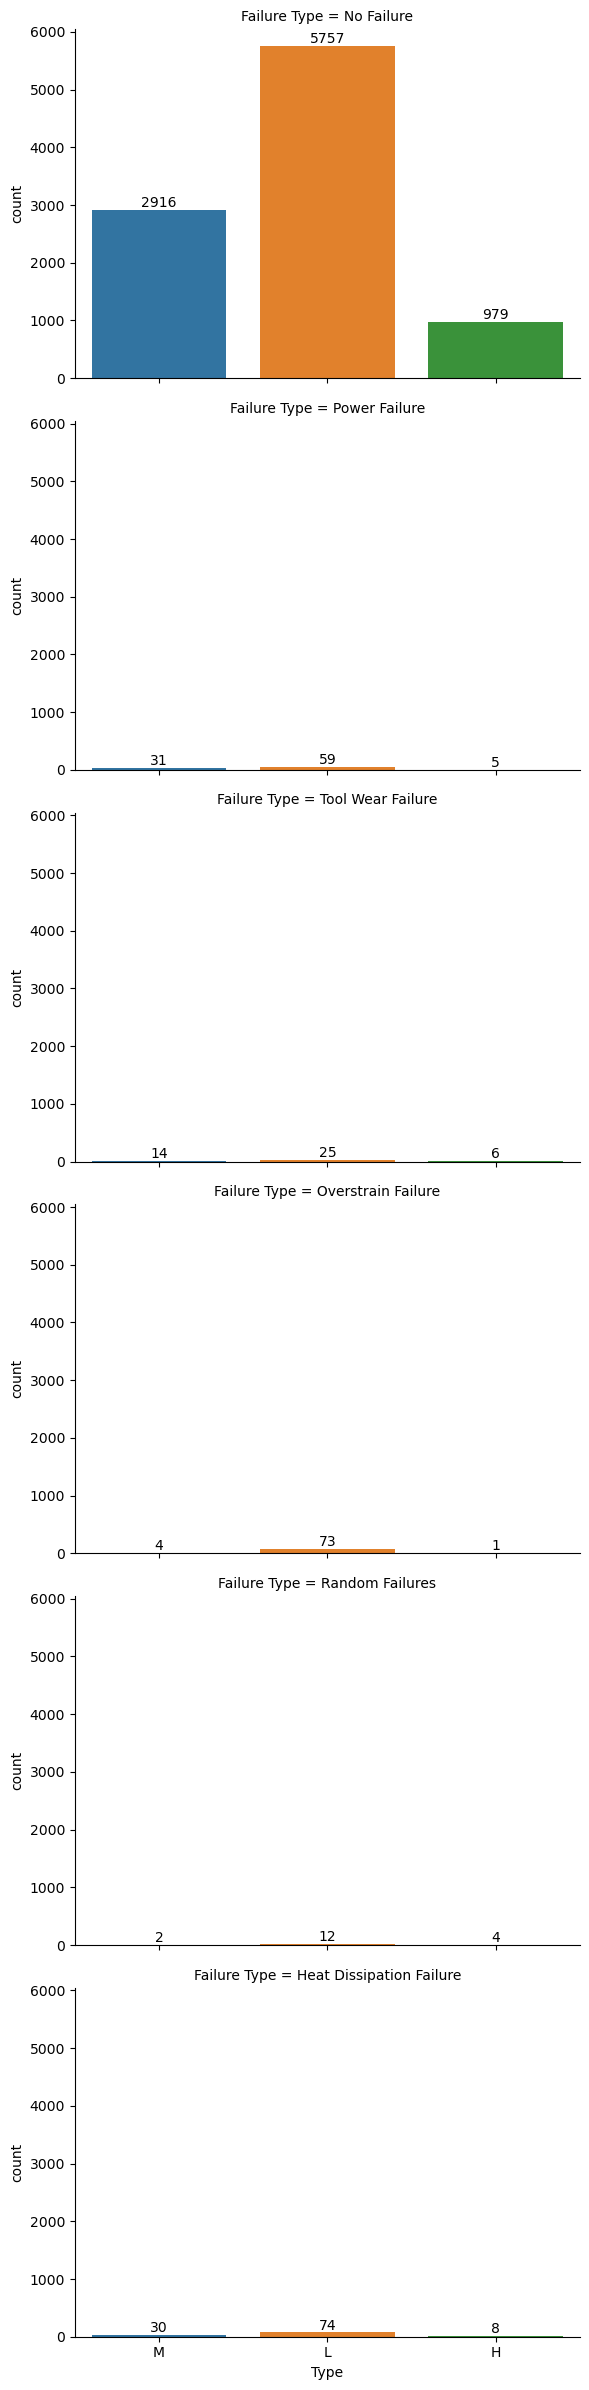

In [19]:
# Categorical BiVariate Plot
bivariate_plot('Failure Type', 'Type')

In [20]:
# Bivariate Plot for numeric features 

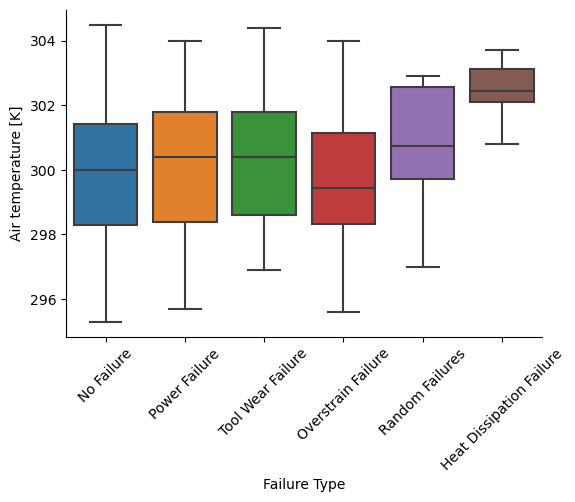

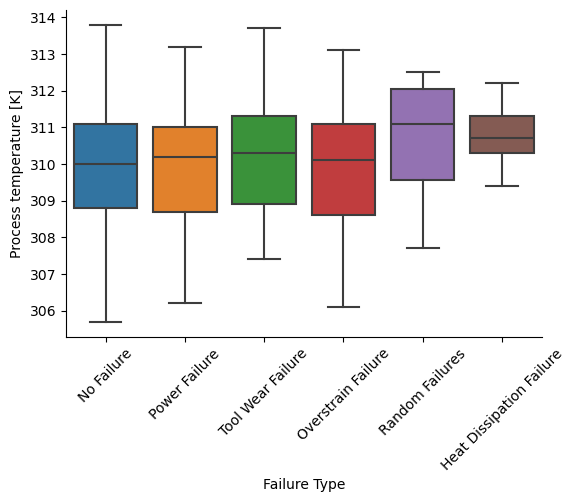

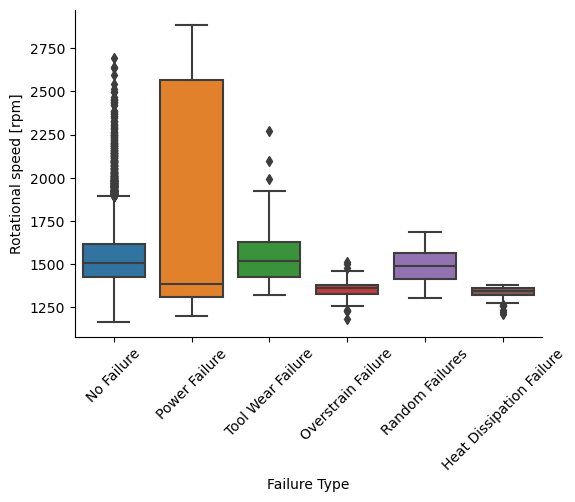

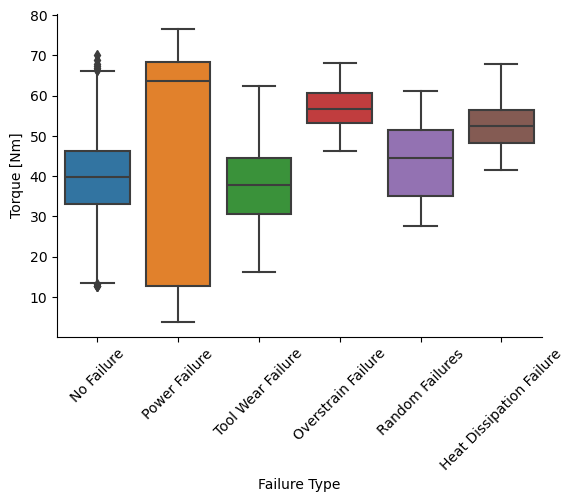

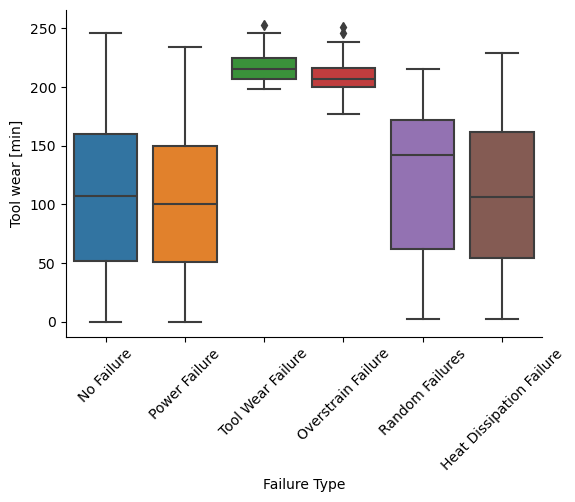

In [21]:
for feature in num_features:
    bivariate_plot('Failure Type', feature) 

## 3. Data Preprocessing

In [22]:
df.rename(columns={'Air temperature [K]': 'Air temperature', 'Process temperature [K]': 'Process temperature', 
                  'Rotational speed [rpm]': 'Rotational speed', 'Torque [Nm]': 'Torque', 'Tool wear [min]':'Tool wear'}, 
               inplace=True) 

In [23]:
df.isnull().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Failure Type           0
dtype: int64

In [24]:
df.duplicated().sum() 

0

In [25]:
# Outlier Detection
def detect_outliers_zscore(data):
    threshold = 3
    outliers = []
    for feature in data.columns:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        
        # Calculate the IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        # Determine outliers for the feature
        outlier_indices = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step)].index
        
        outliers.extend(outlier_indices)
        
    return list(set(outliers))


# Detect outliers
outliers_indices = detect_outliers_zscore(num_features)
outlier_classes = df.loc[outliers_indices, ['Failure Type']]
outlier_classes.value_counts()



Failure Type            
No Failure                  387
Power Failure                65
Tool Wear Failure             4
Overstrain Failure            2
Heat Dissipation Failure      1
Name: count, dtype: int64

**Outliers are showing due to imbalance issues and removal may lead removing important information especialy for the 'Power Failure' class**

## 4. Encoding 

In [26]:
# Do ordinal encoding for type feature 
ordinal_encoder = OrdinalEncoder()  

In [27]:
encoded_column = ordinal_encoder.fit_transform(df['Type'].to_frame())

In [28]:
df['Type Encoded'] = encoded_column # add encoded type to dataframe 
df.drop('Type', axis = 1, inplace = True) # remove type feature 

In [29]:
# Do label encoding for the target feature 
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(df['Failure Type'])
df['Failure Type Encoded'] = encoded_target # add encoded target to dataframe 
df.drop('Failure Type', axis = 1, inplace = True) # remove target 

In [30]:
# Classes mapping show 

class_labels = label_encoder.classes_
numerical_labels = label_encoder.transform(class_labels)

mapping = dict(zip(class_labels, numerical_labels))

print("Mapping of original values to numerical labels:")
print()
for key, value in mapping.items():
    print(f"{key} -> {value}")

Mapping of original values to numerical labels:

Heat Dissipation Failure -> 0
No Failure -> 1
Overstrain Failure -> 2
Power Failure -> 3
Random Failures -> 4
Tool Wear Failure -> 5


In [31]:
df.head()

Air temperature  Process temperature  Rotational speed  Torque  Tool wear  \
0            298.1                308.6              1551    42.8          0   
1            298.2                308.7              1408    46.3          3   
2            298.1                308.5              1498    49.4          5   
3            298.2                308.6              1433    39.5          7   
4            298.2                308.7              1408    40.0          9   

   Type Encoded  Failure Type Encoded  
0           2.0                     1  
1           1.0                     1  
2           1.0                     1  
3           1.0                     1  
4           1.0                     1

## 5. Splitting Criteria

In [32]:


X = df.drop('Failure Type Encoded', axis =1)
y = df['Failure Type Encoded']



In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


In [34]:
y_train.value_counts()

Failure Type Encoded
1    6456
0      80
3      69
2      49
5      33
4      13
Name: count, dtype: int64

In [35]:
y_test.value_counts()

Failure Type Encoded
1    3196
0      32
2      29
3      26
5      12
4       5
Name: count, dtype: int64

## 6. Feature Selection (Based on Correlation)
Let's remove one from the each correalted pair which we found earlier based on the correlation with the target

In [36]:
X_train.head()

Air temperature  Process temperature  Rotational speed  Torque  \
6596            301.5                310.7              1454    39.4   
1292            298.7                309.7              1868    23.8   
2011            298.7                308.5              1616    30.2   
4957            303.8                312.6              1768    23.9   
5164            304.3                313.4              1624    32.1   

      Tool wear  Type Encoded  
6596         17           2.0  
1292        118           2.0  
2011         34           1.0  
4957        149           2.0  
5164         53           2.0

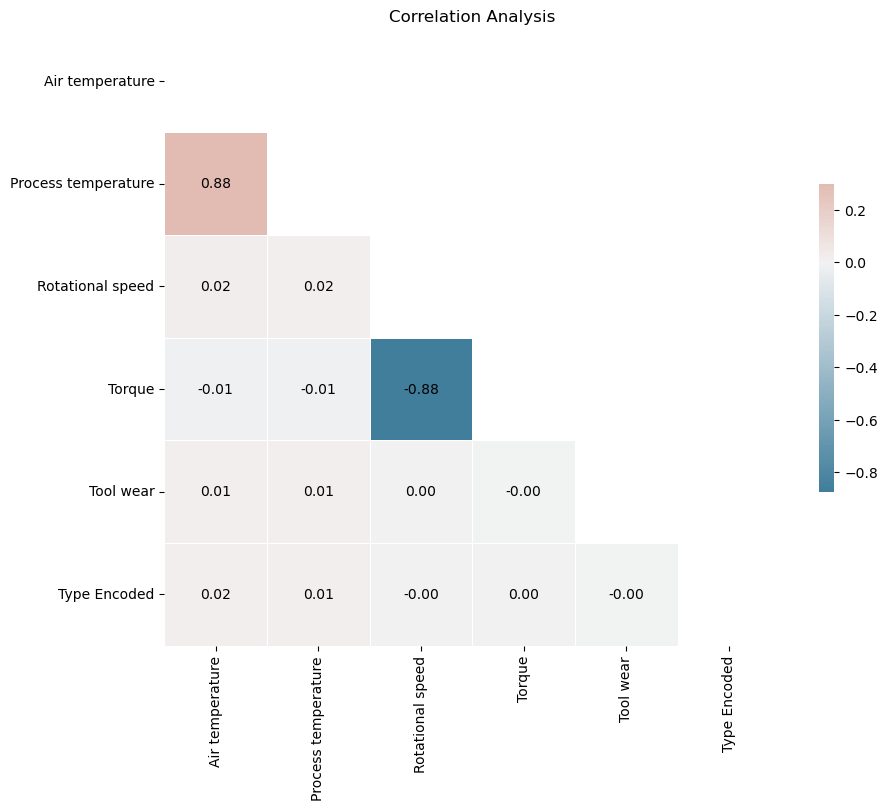

In [37]:
correlation(X) 

In [38]:
feature_selected_X_train = X_train.drop(['Process temperature', 'Torque'], axis = 1) 
feature_selected_X_test = X_test.drop(['Process temperature', 'Torque'], axis = 1) 

## 6. Imbalance Handling

### 6.1. Upsampling

In [39]:
## Imbalance Handling

class_distribution = y_train.value_counts()
print("Class Distribution:")
print(class_distribution)


Class Distribution:
Failure Type Encoded
1    6456
0      80
3      69
2      49
5      33
4      13
Name: count, dtype: int64


In [40]:
# Identify minority and majority classes
minority_classes = class_distribution[class_distribution < class_distribution.max()].index
majority_class = class_distribution.idxmax()

print(minority_classes) 
print(majority_class) 

Index([0, 3, 2, 5, 4], dtype='int32', name='Failure Type Encoded')
1


In [41]:
def upsample(X_train, y_train):    
    # Perform resampling for minority classes
    resampled_X_train = X_train.copy()
    resampled_y_train = y_train.copy()

    for minority_class in minority_classes:
        # Upsample minority class to match the majority class 
        minority_samples = X_train[y_train == minority_class] 
        oversampled_minority_samples = minority_samples.sample(n=class_distribution.max(), replace=True, random_state=42)
        resampled_X_train = pd.concat([resampled_X_train, oversampled_minority_samples])
        resampled_y_train = pd.concat([resampled_y_train, pd.Series([minority_class] * class_distribution.max())])
    
    return resampled_X_train, resampled_y_train


In [42]:
resampled_X_train, resampled_y_train = upsample(X_train, y_train)
resampled_feature_selected_X_train, resampled_feature_selected_y_train = upsample(feature_selected_X_train, y_train)

In [43]:
class_distribution = resampled_y_train.value_counts()
print("Class Distribution:")
print(class_distribution)


Class Distribution:
0    6536
3    6525
2    6505
5    6489
4    6469
1    6456
Name: count, dtype: int64


### 6.2. SMOTE 

In [44]:
smote = SMOTE(random_state=42)


SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)


In [45]:
SMOTE_y_train.value_counts()

Failure Type Encoded
1    6456
3    6456
0    6456
2    6456
4    6456
5    6456
Name: count, dtype: int64

## 7. Model Building

In [46]:
# Performance Checking
def model_fit_score(model,X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Predicted labels: ', y_pred)

    print('accuracy score: ', accuracy_score(y_test, y_pred))
    print('precision score: ', precision_score(y_test, y_pred, average = 'macro'))
    print('recall score: ', recall_score(y_test, y_pred, average = 'macro'))
    print('F1-score: ', f1_score(y_test, y_pred, average = 'macro'))

### 7.1. Raw Dataset Baseline 

In [47]:
lr_model = LogisticRegression()
model_fit_score(lr_model, X_train, y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.97      1.00      0.98      3196
           2       0.47      0.31      0.38        29
           3       1.00      0.15      0.27        26
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        12

    accuracy                           0.97      3300
   macro avg       0.41      0.24      0.27      3300
weighted avg       0.96      0.97      0.96      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9687878787878788
precision score:  0.4079470625171065
recall score:  0.24340604801094204
F1-score:  0.27111046661510696


In [48]:
xgb_model = xgb.XGBClassifier()
model_fit_score(xgb_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.99      1.00      0.99      3196
           2       0.77      0.79      0.78        29
           3       0.88      0.85      0.86        26
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        12

    accuracy                           0.99      3300
   macro avg       0.60      0.59      0.60      3300
weighted avg       0.98      0.99      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9863636363636363
precision score:  0.6008194790800776
recall score:  0.5901356546202204
F1-score:  0.5952219308261225


In [49]:

knn_model = KNeighborsClassifier(n_neighbors = 3)
model_fit_score(knn_model, X_train, y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.10      0.06      0.08        32
           1       0.98      0.99      0.98      3196
           2       0.60      0.41      0.49        29
           3       0.80      0.31      0.44        26
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        12

    accuracy                           0.97      3300
   macro avg       0.41      0.30      0.33      3300
weighted avg       0.96      0.97      0.96      3300

Predicted labels:  [0 1 1 ... 1 1 1]
accuracy score:  0.9672727272727273
precision score:  0.4126642036124795
recall score:  0.29597504036323036
F1-score:  0.3325040659438106


In [50]:

lgbm_model = LGBMClassifier(verbosity=-1)
model_fit_score(lgbm_model, X_train, y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.99      1.00      0.99      3196
           2       0.89      0.83      0.86        29
           3       0.88      0.81      0.84        26
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        12

    accuracy                           0.99      3300
   macro avg       0.63      0.60      0.61      3300
weighted avg       0.98      0.99      0.99      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9887878787878788
precision score:  0.6258637368711996
recall score:  0.5950458976129535
F1-score:  0.6098783866272245


### 7.2. Upsampled 

In [51]:
lr_model = LogisticRegression()
model_fit_score(lr_model, resampled_X_train, resampled_y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.07      0.84      0.13        32
           1       1.00      0.53      0.69      3196
           2       0.15      0.76      0.25        29
           3       0.30      0.88      0.45        26
           4       0.00      0.40      0.00         5
           5       0.04      0.58      0.08        12

    accuracy                           0.53      3300
   macro avg       0.26      0.67      0.27      3300
weighted avg       0.97      0.53      0.68      3300

Predicted labels:  [0 4 4 ... 1 1 4]
accuracy score:  0.5348484848484848
precision score:  0.26096660611494166
recall score:  0.6662046738997723
F1-score:  0.2674482463720557


In [52]:
xgb_model = xgb.XGBClassifier()
model_fit_score(xgb_model, resampled_X_train, resampled_y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.99      0.99      0.99      3196
           2       0.71      0.83      0.76        29
           3       0.79      0.88      0.84        26
           4       0.00      0.00      0.00         5
           5       0.07      0.08      0.08        12

    accuracy                           0.98      3300
   macro avg       0.59      0.63      0.61      3300
weighted avg       0.98      0.98      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9833333333333333
precision score:  0.5887105823920016
recall score:  0.6258163652380831
F1-score:  0.6059660186304924


In [53]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
model_fit_score(knn_model, resampled_X_train, resampled_y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.11      0.28      0.16        32
           1       0.98      0.96      0.97      3196
           2       0.49      0.59      0.53        29
           3       0.50      0.54      0.52        26
           4       0.00      0.00      0.00         5
           5       0.03      0.08      0.04        12

    accuracy                           0.94      3300
   macro avg       0.35      0.41      0.37      3300
weighted avg       0.96      0.94      0.95      3300

Predicted labels:  [0 1 1 ... 1 1 1]
accuracy score:  0.9390909090909091
precision score:  0.351791924279312
recall score:  0.40767879910490823
F1-score:  0.37075175170663927


In [54]:
rf_model = RandomForestClassifier()
model_fit_score(rf_model, resampled_X_train, resampled_y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.81      0.78      0.79        32
           1       0.99      1.00      0.99      3196
           2       0.86      0.62      0.72        29
           3       0.77      0.77      0.77        26
           4       0.00      0.00      0.00         5
           5       0.33      0.08      0.13        12

    accuracy                           0.98      3300
   macro avg       0.63      0.54      0.57      3300
weighted avg       0.98      0.98      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9836363636363636
precision score:  0.6257773866227704
recall score:  0.5416872136903372
F1-score:  0.5680441298835687


In [55]:

lgbm_model = LGBMClassifier(verbosity=-1)
model_fit_score(lgbm_model, resampled_X_train, resampled_y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.99      0.99      0.99      3196
           2       0.77      0.79      0.78        29
           3       0.79      0.88      0.84        26
           4       0.00      0.00      0.00         5
           5       0.14      0.08      0.11        12

    accuracy                           0.99      3300
   macro avg       0.61      0.62      0.61      3300
weighted avg       0.98      0.99      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9857575757575757
precision score:  0.6053345554588043
recall score:  0.6153823906577888
F1-score:  0.608599677401942


## 7.3 Feature Selected Dataset
Checking weather the feature selection criteria helps improve the performance

In [57]:
xgb_model = xgb.XGBClassifier()
model_fit_score(xgb_model, resampled_feature_selected_X_train, resampled_feature_selected_y_train, feature_selected_X_test, y_test)



              precision    recall  f1-score   support

           0       0.36      0.50      0.42        32
           1       0.98      0.97      0.98      3196
           2       0.34      0.52      0.41        29
           3       0.33      0.27      0.30        26
           4       0.00      0.00      0.00         5
           5       0.06      0.08      0.07        12

    accuracy                           0.95      3300
   macro avg       0.34      0.39      0.36      3300
weighted avg       0.96      0.95      0.96      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9548484848484848
precision score:  0.3445095008975135
recall score:  0.3905871047179148
F1-score:  0.36146272102631083


In [59]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
model_fit_score(knn_model, resampled_feature_selected_X_train, resampled_feature_selected_y_train, feature_selected_X_test, y_test)


              precision    recall  f1-score   support

           0       0.13      0.25      0.17        32
           1       0.98      0.95      0.96      3196
           2       0.33      0.48      0.39        29
           3       0.16      0.38      0.23        26
           4       0.00      0.00      0.00         5
           5       0.03      0.08      0.04        12

    accuracy                           0.93      3300
   macro avg       0.27      0.36      0.30      3300
weighted avg       0.95      0.93      0.94      3300

Predicted labels:  [3 3 1 ... 1 1 1]
accuracy score:  0.9275757575757576
precision score:  0.27276749594000627
recall score:  0.35802360525074267
F1-score:  0.30035082873410074


**The performance lowered significantly. So, we can reject the feature selected dataset**

### 7.4. SMOTE Data

In [60]:
xgb_model = xgb.XGBClassifier()
model_fit_score(xgb_model, SMOTE_X_train, SMOTE_y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.99      0.97      0.98      3196
           2       0.69      0.86      0.77        29
           3       0.74      0.88      0.81        26
           4       0.00      0.00      0.00         5
           5       0.05      0.17      0.08        12

    accuracy                           0.97      3300
   macro avg       0.58      0.65      0.61      3300
weighted avg       0.98      0.97      0.97      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9651515151515152
precision score:  0.5798457622852631
recall score:  0.647375357201217
F1-score:  0.6056654803942311


In [61]:
rf_model = RandomForestClassifier()
model_fit_score(rf_model, SMOTE_X_train, SMOTE_y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.70      0.94      0.80        32
           1       0.99      0.97      0.98      3196
           2       0.57      0.79      0.67        29
           3       0.68      0.81      0.74        26
           4       0.00      0.00      0.00         5
           5       0.06      0.17      0.09        12

    accuracy                           0.96      3300
   macro avg       0.50      0.61      0.55      3300
weighted avg       0.98      0.96      0.97      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9633333333333334
precision score:  0.5004512511139487
recall score:  0.6126439248404744
F1-score:  0.5456230973808124


In [62]:

lgbm_model = LGBMClassifier(verbosity=-1)
model_fit_score(lgbm_model, SMOTE_X_train, SMOTE_y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.99      0.98      0.99      3196
           2       0.77      0.93      0.84        29
           3       0.77      0.88      0.82        26
           4       0.00      0.00      0.00         5
           5       0.06      0.17      0.09        12

    accuracy                           0.97      3300
   macro avg       0.59      0.66      0.62      3300
weighted avg       0.98      0.97      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9727272727272728
precision score:  0.5896244170437719
recall score:  0.6600690260113676
F1-score:  0.6189771926455695


### 7.5. Using Class Weight 

In [63]:
class_distribution = y_train.value_counts().to_dict()

total_samples = sum(class_distribution.values())
class_weights = {class_label: total_samples / (len(class_distribution) * class_count) for class_label, class_count in class_distribution.items()}

# Adjust class weights for minority classes
minority_classes = list(class_distribution.keys())
for class_label in minority_classes:
    class_weights[class_label] *= 5  # Adjust weights for minority classes
    


In [64]:
minority_classes

[1, 0, 3, 2, 5, 4]

In [65]:
class_weights

{1: 0.8648285832300702,
 0: 69.79166666666667,
 3: 80.91787439613526,
 2: 113.94557823129253,
 5: 169.1919191919192,
 4: 429.4871794871795}

In [66]:

lgbm_model = LGBMClassifier(class_weight = class_weights, verbosity=-1)
model_fit_score(lgbm_model, X_train, y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.99      0.99      0.99      3196
           2       0.73      0.83      0.77        29
           3       0.85      0.85      0.85        26
           4       0.00      0.00      0.00         5
           5       0.08      0.08      0.08        12

    accuracy                           0.98      3300
   macro avg       0.59      0.61      0.60      3300
weighted avg       0.98      0.98      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9839393939393939
precision score:  0.5879542512834127
recall score:  0.6092501847560704
F1-score:  0.59802769038911


In [67]:
xgb_model = xgb.XGBClassifier(class_weight = class_weights)
model_fit_score(xgb_model, X_train, y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.99      1.00      0.99      3196
           2       0.77      0.79      0.78        29
           3       0.88      0.85      0.86        26
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        12

    accuracy                           0.99      3300
   macro avg       0.60      0.59      0.60      3300
weighted avg       0.98      0.99      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9863636363636363
precision score:  0.6008194790800776
recall score:  0.5901356546202204
F1-score:  0.5952219308261225


**LGBM Model with SMOTE dataset performed better than other approches. Let's try tuning the hyperparameters**

## 8. Hyperparameter Tuning

In [68]:
!pip install scikit-optimize

In [69]:
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_classes': 5,  
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        # Add more hyperparameters to tune
    }

    lgbm_model = LGBMClassifier(**params)
    lgbm_model.fit(SMOTE_X_train, SMOTE_y_train)
    y_pred = lgbm_model.predict(X_test)
    
    score = precision_score(y_test, y_pred, average = 'macro')
    
    # Return the average F1-score across all minority classes
    return score

In [72]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2024-05-09 19:02:05,489] A new study created in memory with name: no-name-b1c7bf47-56a1-4c24-88e7-0c72d5db500c
[I 2024-05-09 19:02:06,617] Trial 0 finished with value: 0.5825434502507435 and parameters: {'num_leaves': 213, 'learning_rate': 0.4529060843692911, 'feature_fraction': 0.6504065338185375, 'max_depth': 11}. Best is trial 0 with value: 0.5825434502507435.
[I 2024-05-09 19:02:07,205] Trial 1 finished with value: 0.36394840593423544 and parameters: {'num_leaves': 63, 'learning_rate': 0.009217294669067193, 'feature_fraction': 0.9219972579174794, 'max_depth': 3}. Best is trial 0 with value: 0.5825434502507435.
[I 2024-05-09 19:02:08,528] Trial 2 finished with value: 0.41999492590575266 and parameters: {'num_leaves': 100, 'learning_rate': 0.047757558414244956, 'feature_fraction': 0.284146546160364, 'max_depth': 15}. Best is trial 0 with value: 0.5825434502507435.
[I 2024-05-09 19:02:09,574] Trial 3 finished with value: 0.5804113952659907 and parameters: {'num_leaves': 60, 'learni

[I 2024-05-09 19:02:41,196] Trial 32 finished with value: 0.5446666400121595 and parameters: {'num_leaves': 237, 'learning_rate': 0.40141761024584144, 'feature_fraction': 0.5178119703067069, 'max_depth': 3}. Best is trial 26 with value: 0.6000384628315586.
[I 2024-05-09 19:02:42,705] Trial 33 finished with value: 0.5998879292513131 and parameters: {'num_leaves': 181, 'learning_rate': 0.23465466110231067, 'feature_fraction': 0.7287425404116753, 'max_depth': 8}. Best is trial 26 with value: 0.6000384628315586.
[I 2024-05-09 19:02:43,976] Trial 34 finished with value: 0.5716720251142257 and parameters: {'num_leaves': 183, 'learning_rate': 0.36690231387333605, 'feature_fraction': 0.7175759694677564, 'max_depth': 10}. Best is trial 26 with value: 0.6000384628315586.
[I 2024-05-09 19:02:44,640] Trial 35 finished with value: 0.5526255350399483 and parameters: {'num_leaves': 225, 'learning_rate': 0.13364418198409228, 'feature_fraction': 0.6362891668648959, 'max_depth': 4}. Best is trial 26 wit

[I 2024-05-09 19:03:26,314] Trial 64 finished with value: 0.5846673549836185 and parameters: {'num_leaves': 101, 'learning_rate': 0.15831702050472332, 'feature_fraction': 0.9174884563587951, 'max_depth': 15}. Best is trial 43 with value: 0.6112456337961741.
[I 2024-05-09 19:03:27,810] Trial 65 finished with value: 0.5900300205736421 and parameters: {'num_leaves': 68, 'learning_rate': 0.08531224093775615, 'feature_fraction': 0.9951853845870413, 'max_depth': 16}. Best is trial 43 with value: 0.6112456337961741.
[I 2024-05-09 19:03:29,495] Trial 66 finished with value: 0.5799862714446048 and parameters: {'num_leaves': 89, 'learning_rate': 0.06354432799783942, 'feature_fraction': 0.8785273436084872, 'max_depth': 12}. Best is trial 43 with value: 0.6112456337961741.
[I 2024-05-09 19:03:30,553] Trial 67 finished with value: 0.6184654123608799 and parameters: {'num_leaves': 33, 'learning_rate': 0.14847169397576832, 'feature_fraction': 0.809631316841401, 'max_depth': 16}. Best is trial 67 with

[I 2024-05-09 19:04:01,800] Trial 96 finished with value: 0.34472347874271403 and parameters: {'num_leaves': 78, 'learning_rate': 0.10917294019854631, 'feature_fraction': 0.22711765141497214, 'max_depth': 10}. Best is trial 67 with value: 0.6184654123608799.
[I 2024-05-09 19:04:02,705] Trial 97 finished with value: 0.6006266766643801 and parameters: {'num_leaves': 20, 'learning_rate': 0.21098071747732267, 'feature_fraction': 0.7792605702579517, 'max_depth': 8}. Best is trial 67 with value: 0.6184654123608799.
[I 2024-05-09 19:04:03,726] Trial 98 finished with value: 0.6023306032731451 and parameters: {'num_leaves': 100, 'learning_rate': 0.4381787803468007, 'feature_fraction': 0.884331627948267, 'max_depth': 9}. Best is trial 67 with value: 0.6184654123608799.
[I 2024-05-09 19:04:05,010] Trial 99 finished with value: 0.5943278888374988 and parameters: {'num_leaves': 117, 'learning_rate': 0.26545201371804406, 'feature_fraction': 0.6350799785441645, 'max_depth': 12}. Best is trial 67 with

Best hyperparameters: {'num_leaves': 33, 'learning_rate': 0.14847169397576832, 'feature_fraction': 0.809631316841401, 'max_depth': 16}


In [ ]:
best_params

In [73]:
# DEFAULT RESULTS
lgbm_model = LGBMClassifier(verbosity=-1)
model_fit_score(lgbm_model, SMOTE_X_train, SMOTE_y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.99      0.98      0.99      3196
           2       0.77      0.93      0.84        29
           3       0.77      0.88      0.82        26
           4       0.00      0.00      0.00         5
           5       0.06      0.17      0.09        12

    accuracy                           0.97      3300
   macro avg       0.59      0.66      0.62      3300
weighted avg       0.98      0.97      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9727272727272728
precision score:  0.5896244170437719
recall score:  0.6600690260113676
F1-score:  0.6189771926455695


In [74]:
# TUNED RESULTS
lgbm_model = LGBMClassifier(num_leaves= 165, learning_rate=  0.21659850764785168, 
                            feature_fraction= 0.87647270659664028, max_depth= 7,
                            verbosity=-1)
model_fit_score(lgbm_model, SMOTE_X_train, SMOTE_y_train, X_test, y_test)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.99      0.98      0.99      3196
           2       0.81      0.86      0.83        29
           3       0.85      0.85      0.85        26
           4       0.00      0.00      0.00         5
           5       0.06      0.17      0.09        12

    accuracy                           0.98      3300
   macro avg       0.62      0.64      0.63      3300
weighted avg       0.99      0.98      0.98      3300

Predicted labels:  [1 1 1 ... 1 1 1]
accuracy score:  0.9754545454545455
precision score:  0.618412319129165
recall score:  0.6427902989553328
F1-score:  0.6266798797885839


## 9. Dump Model and Preprocessing Steps

In [ ]:
import pickle
# model_filename = 'maintenance-failure-model.pkl'
# pickle.dump(lgbm_model, open(model_filename,'wb'))

model = pickle.load(open('maintenance-failure-model.pkl','rb'))


In [ ]:
model.predict([X_test.loc[9822]]).item()

In [ ]:
np.array([df.loc[9394]])

In [ ]:

pickle.dump(ordinal_encoder, open('encoder.pkl', 'wb'))

In [ ]:
X_test[X_test.index.isin(y_test[y_test == 2].index)]